# Accompanying notebook to Optimization Stories in Logistics and Transportation

By Joaquim Gromicho, ORTEC & The Analytics Academy, 2020

------------------

Let us suppose now that Caroline is so successful that she considers opening a number of distribution centers to support scaling up her production. 

She asks Gina to optimally decide which centers to select.

Taking into account her costumers $J$ and a set $I$ of possible locations for her new distribution centers she estimates the costs $c_j$ of opening at $j \in J$ and $d_{ij}$ of serving $i \in I$ from $j \in J$.

Her decision variables are:
     
$$
   x_j = \left\{
     \begin{array}{lr}
       1 & \mbox{center } j \mbox{ is built}\\
       0 & \mbox{otherwise}\\
     \end{array}
   \right.
       \mbox{ and }
   y_{ij} = \left\{
     \begin{array}{lr}
       1 & \mbox{customer } i \mbox{ is served at } j\\
       0 & \mbox{otherwise}\\
     \end{array}
   \right.
$$

Minimizing the number of bins used provided that each item goes in a bin and the sum of the sizes $s_i$ of items in the same bin do not exceed the capacity $c$ is:
$$
\begin{array}{rrcll}
\min    & \sum_{j\in J} c_jx_j + \sum_{i \in I, j \in J} d_{ij}y_{ij}\\
s.t.    & \sum_{j\in J} y_{ij}     & =    & 1     & \forall i \in I \\
        & \sum_{i\in I} y_{ij}     & \leq & n x_j & \forall j \in J \\
        & y_{ij} \in \{0,1\}       &      &       & \forall i \in I, j \in J \\
        & x_j \in \{0,1\}          &      &       & \forall j \in J \\
\end{array}
$$
       
The disaggregated model which is claimed to be stronger is:
$$
\begin{array}{rrcll}
\min    & \sum_{j\in J} c_jx_j + \sum_{i \in I, j \in J} d_{ij}y_{ij}\\
s.t.    & \sum_{j\in J} y_{ij}     & =    & 1     & \forall i \in I \\
        &               y_{ij}     & \leq & x_j   & \forall i \in I, j \in J \\
        & y_{ij} \in \{0,1\}       &      &       & \forall i \in I, j \in J \\
        & x_j \in \{0,1\}          &      &       & \forall j \in J \\
\end{array}
$$

In [1]:
%matplotlib inline

In [2]:
def FacilityLocationWeak( installation, service, solver='glpk' ):
    from pyomo.environ import ConcreteModel, Var, Objective, Constraint, NonNegativeReals, Binary, minimize
    
    model = ConcreteModel("Gina's facility location")    
    model.nofFacilities = len( installation )
    model.nofCustomers  = len( service )
    model.facilities = range( model.nofFacilities ) 
    model.customers  = range( model.nofCustomers )
    
    model.x = Var( model.facilities, within=Binary )
    model.y = Var( model.customers, model.facilities, within=NonNegativeReals )
        
    model.obj = Objective ( expr = sum([installation[j]*model.x[j] for j in model.facilities])                          \
                                 + sum([service[i][j]*model.y[i,j] for i in model.customers for j in model.facilities]) \
                          , sense=minimize)

    def ServeIfOpen( model, j ):
        return sum([model.y[i,j] for i in model.customers]) <= model.nofCustomers*model.x[j]
    
    def ChooseOneFacility( model, i ):
        return sum([model.y[i,j] for j in model.facilities]) == 1

    model.serve  = Constraint( model.facilities, rule=ServeIfOpen )
    model.choose = Constraint( model.customers, rule=ChooseOneFacility )
    
    from pyomo.opt import SolverFactory
    %time results = SolverFactory(solver).solve(model)
    
    X = [ model.x[j].value >= .5 for j in model.facilities ]
    Y = [ [ model.y[i,j].value >= .5 for j in model.facilities ] for i in model.customers ]
    
    return X, Y, model.obj.expr()

def FacilityLocationStrong( installation, service, solver='glpk' ):
    from pyomo.environ import ConcreteModel, Var, Objective, Constraint, NonNegativeReals, Binary, minimize
    
    model = ConcreteModel("Gina's facility location")    
    model.nofFacilities = len( installation )
    model.nofCustomers  = len( service )
    model.facilities = range( model.nofFacilities ) 
    model.customers  = range( model.nofCustomers )
    
    model.x = Var( model.facilities, within=Binary )
    model.y = Var( model.customers, model.facilities, within=NonNegativeReals )
        
    model.obj = Objective ( expr = sum([installation[j]*model.x[j] for j in model.facilities])                          \
                                 + sum([service[i][j]*model.y[i,j] for i in model.customers for j in model.facilities]) \
                          , sense=minimize)

    def ServeIfOpen( model, i, j ):
        return model.y[i,j] <= model.x[j]
    
    def ChooseOneFacility( model, i ):
        return sum([model.y[i,j] for j in model.facilities]) == 1

    model.serve  = Constraint( model.customers, model.facilities, rule=ServeIfOpen )
    model.choose = Constraint( model.customers, rule=ChooseOneFacility )
    
    from pyomo.opt import SolverFactory
    %time results = SolverFactory(solver).solve(model)
    
    X = [ model.x[j].value >= .5 for j in model.facilities ]
    Y = [ [ model.y[i,j].value >= .5 for j in model.facilities ] for i in model.customers ]
    
    return X, Y, model.obj.expr()

In [3]:
def GenerateFacilityLocationInstance( nofFacilities, nofCustumers ):
    facilities = range(nofFacilities)
    customers = range(nofCustumers)
    import numpy as np
    xC = np.random.randint( 0, 100, nofCustumers )    
    yC = np.random.randint( 0, 100, nofCustumers )
    xF = np.random.randint( 0, 100, nofFacilities )    
    yF = np.random.randint( 0, 100, nofFacilities )
    
    installation = np.random.randint( 100, 200, nofFacilities )

    dist = lambda i,j : ((xC[i]-xF[j])**2 + (yC[i]-yF[j])**2)
    
    service = [ [ dist(i,j) for j in facilities ] for i in customers ]
    
    return installation, service, xC, yC, xF, yF

In [4]:
def ShowFacilityLocation( xC, yC, xF, yF, X=[], Y=[], cost=None ):
    import matplotlib.pyplot as plt
    [ plt.plot( [xC[i],xF[j]], [yC[i],yF[j]], 'g-' ) for j in range(len(X)) if X[j] for i in range(len(Y)) if Y[i][j] ] 
    plt.plot( xC,yC, 'o' )
    plt.plot( xF,yF, 's' )
    if not cost is None:
        plt.title( str(cost) )
    plt.show()

In [5]:
installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(30,50)

In [6]:
ShowFacilityLocation( xC, yC, xF, yF )

Wall time: 27.3 s


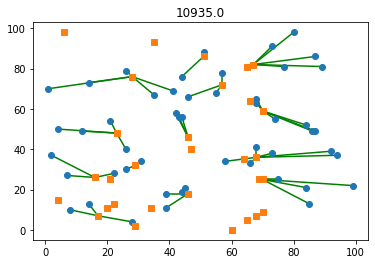

Wall time: 29.4 s


In [7]:
solver = 'glpk'
%time ShowFacilityLocation( xC, yC, xF, yF, *FacilityLocationWeak( installation, service, solver=solver ) )

Wall time: 441 ms


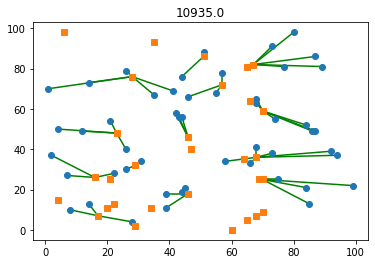

Wall time: 825 ms


In [8]:
%time ShowFacilityLocation( xC, yC, xF, yF, *FacilityLocationStrong( installation, service, solver=solver ) )